# Object Detection e Instance Segmentation em Pytorch

O principal dataset de Instance Segmentation atual (o MS-COCO) possui a sua própria API com funcionalidades que ajudam no load dos dados e na avaliação de resultados no dataset. Essa API é pensada para ser integrada com o Pytorch e o torchvision, portanto vamos baixá-la para que possamos utilizar algumas funcionalidades no dataset que utilizaremos nesse notebook.

In [0]:
%%shell

# Install pycocotools
git clone https://github.com/cocodataset/cocoapi.git
cd cocoapi/PythonAPI
python setup.py build_ext install

# Baixando e carregando o dataset Penn-Fudan

O dataset [*Penn-Fudan*](https://www.cis.upenn.edu/~jshi/ped_html/) para detecção e segmentação de pedestres contém apenas 170 imagens com 345 instâncias de pedestres. Como não há uma classe *Dataset* padrão para esse dataset no Pytorch, precisaremos implementar o load dos dados manualmente com um *Dataset* personalizado.

Primeiramente precisamos baixar o dataset que pode ser encontrado em formato zip: [PennFudanPed.zip](https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip).

In [0]:
!rm -r ./*

# Download the Penn-Fudan dataset.
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -O PennFudanPed.zip

# Extract it in the current folder.
!unzip -q PennFudanPed.zip

A estrutura de pastas do dataset após extração do zip é organizada como mostrado abaixo:

```
PennFudanPed/
  PedMasks/
    FudanPed00001_mask.png
    FudanPed00002_mask.png
    FudanPed00003_mask.png
    FudanPed00004_mask.png
    ...
  PNGImages/
    FudanPed00001.png
    FudanPed00002.png
    FudanPed00003.png
    FudanPed00004.png
```

Podemos carregar e plotar rapidamente uma imagem do dataset usando a biblioteca [PIL](https://pillow.readthedocs.io/en/stable/).

In [0]:
from PIL import Image

Image.open('PennFudanPed/PNGImages/FudanPed00001.png')

In [0]:
mask = Image.open('PennFudanPed/PedMasks/FudanPed00001_mask.png')

# Each mask instance has a different color, from zero to N, where N is the
# number of instances. In order to make visualization easier, let's add a color
# palette to the mask.
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])

mask

Cada imagem tem uma máscara de segmentação com uma cor correspondendod a cada instância diferente de um pedestre. Precisamos, portanto, construir uma subclasse da classe *Dataset* do Pytorch que implemente a leitura desse tipo específico de dado.

O torchvision contém [scripts de referência](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) que podem ser usados para se adaptar código existente para uma nova tarefa de Detecção de Objetos, Detecção de Keypoints ou Instance Segmentation. Para integração com esse código, o *Dataset* customizado para o novo conjunto de dados deve retornar no método *\_\_getitem\_\_()* uma sequência específica de dados:

* image: uma imagem no formato da biblioteca PIL com dimensões (H, W)
* target: um dicionário contendo os seguintes campos:
    * `'boxes'` (`FloatTensor[N, 4]`): coordenadas dos `N` bounding boxes no formato `[x0, y0, x1, y1]`, com valores no eixo $x$ no intervalo [$0$, $W$] e no eixo $y$ no intervalo [$0$, $H$];
    * `'labels'` (`Int64Tensor[N]`): o rótulo de classe de cada bounding box;
    * `'image_id'` (`Int64Tensor[1]`): um identificador para a imagem. Esse identificador deve ser único entre todas as amostras do dataset e é usado pela função de avaliação;
    * `'area'` (`Tensor[N]`): a área do bounding box, ou seja, (`x1`-`x0`) $\times$ (`y1`-`y0`). Essa informação é utilizada no método de avaliação que estamos reaproveitando da biblioteca do dataset COCO;
    * `'iscrowd'` (`UInt8Tensor[N]`): instâncias com o atributo `iscrowd=True` serão ignoradas durante a avaliação da performance da rede. No nosso caso, assumiremos sempre que `iscrowd=False` devido às características do dataset Penn-Fudan;
    * (opcional) `'masks'` (`UInt8Tensor[N, H, W]`): as máscaras de segmentação para cada objeto na cena;
    * (opcional) `'keypoints'` (`FloatTensor[N, K, 3]`): os `K` keypoints presentes em cada objeto no formato `[x, y, visibility]` (na última dimensão do tensor).


In [0]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    
    def __init__(self, root, transforms=None):
        
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        
        return len(self.imgs)

Imprimindo uma amostra para demonstrar como está estruturado cada sample do dataset.

In [0]:
dataset = PennFudanDataset('PennFudanPed/')
dataset[0]

Pode-se ver que o dataset retorna uma imagem no formato da biblioteca [PIL](https://pillow.readthedocs.io/en/stable/) e um dicionário contendo várias informações dos bounding boxes na imagem e segmentações desses bounding boxes. É notável que a estrutura desses dados é consideravelmente mais complexa do que os datasets que foram usados/implementados nas aulas anteriores.

# Detecção em Imagens

Os principais modelos de detecção são os da família das Regional CNNs (R-CNNs). Entre 2014 e 2016 foram propostos três artigo seminais usando como base R-CNNs:

1.   A [R-CNN clássica](https://arxiv.org/pdf/1311.2524.pdf);
2.   A [Fast R-CNN](https://arxiv.org/pdf/1504.08083.pdf);
3.   E a [Faster R-CNN](https://arxiv.org/pdf/1506.01497.pdf).

Como os nomes indicam, as arquiteturas de detecção foram sendo otimizadas para serem rodadas em tempo real, de modo que pudessem ser usadas em aplicações como carros autônomos. Toda a família das R-CNNs parte de um princípio consideravelmente simples: alimentar subregiões de imagens para uma CNN pré-treinada em um dataset grande e obter uma predição para qual tipo de objeto está naquele patch da imagem. R-CNNs clássicas usavam a CNN apenas como extratora de features, contando com uma seleção de patches feita pelo algoritmo [Selective Search](https://ivi.fnwi.uva.nl/isis/publications/2013/UijlingsIJCV2013/) e uma classificação usando um [SVM](https://link.springer.com/article/10.1007%2FBF00994018) para realizar a inferência da classe do patch. O esquema de uma R-CNN clássica pode ser visto nas imagens abaixo.

![R-CNN Clássica 1](https://miro.medium.com/max/700/1*REPHY47zAyzgbNKC6zlvBQ.png)

![R-CNN Clássica 2](https://miro.medium.com/max/556/1*NX5yYTi-eQjP0pMWs3UbUg.png)

R-CNNs clássicas são altamente limitadas em qualidade de detecção e eficiência por uma série de fatores, incluindo a quantidade enorme de regiões propostas pelo Selective Search (~2000 regiões por imagem, que tinham que ser passadas pela CNN) e a impossiblidade de backpropagar erro de acordo com as predições de classe do SVM que fazia a inferência. Visando mitigar parte desses problemas, a primeira arquitetura que usava a própria CNN para realizar as inferências das classes dos patches foi a Fast R-CNN. A Fast R-CNN permitia uma integração do pipeline de inferência com a extração de features, de forma que a extração poderia ser tunada para as especificações do dataset, ao invés de usar uma CNN pré-treinada sem fine-tuning. 

![Fast R-CNN](https://miro.medium.com/max/700/1*0pMP3aY8blSpva5tvWbnKA.png)

Além de ganhos expressivos em qualidade de detecção as Fast R-CNNs faziam o forward da imagem apenas uma vez pela CNN e selecionavam os patches candidatos usando os feature maps retornados pela CNN, ao invés de passar os ~2000 patches separadamente pela rede como fazia a R-CNN. Isso trouxe ganhos de desempenho de treinamento de aproximadamente uma ordem de magnitude e ganhos no tempo de teste entre uma e duas ordens de magnitude, como pode ser visto na figura abaixo.

![Time Comparison 1](https://miro.medium.com/max/700/1*m2QO_wbUPA05mY2q4v7mjg.png)

Fast R-CNNs ainda usavam um algoritmo de seleção de regiões não integrado à arquitetura, o que impossibilitava o uso em tempo real dessa arquitetura, já que uma imagem levava aproximadamente 2 segundos para ser processada. O gargalo de eficiência da arquitetura passou, então, a ser o algoritmo de proposição de regiões e não mais os forwards dos patches pela CNN. Pouco tempo depois, as Faster R-CNNs foram propostas por parte do mesmo time de pesquisadores que propôs a R-CNN clássica e a Fast R-CNN, finalmente integrando todo o pipeline de detecção. Além da completa e total falta de criatividade dos pesquisadores para nomear arquiteturas, é notável que as Faster R-CNNs permitem um treinamento end-to-end da arquitetura toda ao incluir uma Region Proposal Network (RPN) para substituir o Selective Search, que era o gargalo da Fast R-CNN. Os gradientes da RPN propagavam para a CNN extratora de features, ajudando no treinamento, bem como se aproveitavam dos gradientes da classificação dos patches. Dessa forma, além do considerável ganho de eficiência, todas as subtarefas do treinamento podiam se ajudar mutuamente.

![Faster R-CNN](https://miro.medium.com/max/700/1*pSnVmJCyQIRKHDPt3cfnXA.png)

Em 2016, pela primeira vez havia uma arquitetura end-to-end para detecção de objetos que podia ser executada numa escala próxima de em tempo real, já que, mais uma vez, o ganho de eficiência em relação às Fast R-CNNs foi por volta de uma ordem de magnitude. Implementações eficientes de Faster R-CNNs conseguem processar até 5 frames/segundo.

![Time Comparison 2](https://miro.medium.com/max/700/1*4gGddZpKeNIPBoVxYECd5w.png)

# Aproveitando as arquiteturas do torchvision

Há duas formas principais para se reaproveitar as arquiteturas de detecção pré-treinadas do torchvision:

1.   Começar com o modelo pré-treinado e apenas fazer o fine-tuning da última camada;
2.   Modificar o modelo para adicionar um backbone diferente do padrão (ResNet-50), a qual pode ser demasiadamente grande para algumas aplicações.

No nosso exemplo, como a ResNet-50/Faster R-CNN já haviam sido treinadas com um dataset consideravelmente parecido com o Penn-Fudan (o [MS-COCO](http://cocodataset.org)), queremos aproveitar toda a estrutura e modificar apenas o módulo do preditor de bounding boxes para o novo dataset.

In [0]:
from torch import nn

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = None
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
# The Penn-Fudan dataset has only two classes: background and person.
num_classes = 2

# Load an instance segmentation model pre-trained on COCO.
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

# print(model)

# Getting the number of input features for the classifier.
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained Box Prediction Head with a new one.
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

print(model.roi_heads.box_predictor)

# Instance Segmentation

Dentre as tarefas clássicas da área de Visão Computacional, Instance Segmentation é considerada uma das mais difíceis e não havia forma eficiente de realizá-la usando Deep Learning até 2017. Essa tarefa requer que o algoritmo tenha discernimento entre diferentes objetos da mesma classe numa mesma imagem, sabendo discerní-los. A diferença entre Instance Segmentation e Semantic Segmentation é ilustrada nas imagens abaixo.

![Semantic Segmentation](https://i.loli.net/2017/09/12/59b6d1993b0fe.png)

![Instance Segmentation](https://i.loli.net/2017/09/12/59b6f7187a586.png)

Em 2017 foi proposta a [Mask R-CNN](https://arxiv.org/pdf/1703.06870.pdf), que é considerada até hoje o estado-da-arte para Instance Segmentation. A Mask R-CNN (novamente proposta pelo mesmo time da R-CNN clássica, Fast R-CNN e Faster R-CNN) conta com uma Faster R-CNN para realizar a detecção dos objetos, passando a saída de cada patch detectado por uma rede de segmentação (i.e. FCN, U-Net, SegNet...), como pode ser visto nas imagens abaixo.

![Mask R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image04.png)

![Mask R-CNN Details](https://www.dropbox.com/s/b1hnjon5lxp2qps/Mask_RCNN_Scheme.png?dl=1)

Como vamos aproveitar a rede pré-treinada do torchvision, também precisamos modificar o módulo de segmentação da Mask R-CNN para o novo dataset.

In [0]:
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# Getting the number of input features for the mask classifier.
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256

# Replacing the mask predictor with a new one.
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                   hidden_layer,
                                                   num_classes)

print(model.roi_heads.mask_predictor)

# Casting model to device.
model.to(device)

# Funções de treinamento e avaliação do desempenho da rede

O torchvision possui em um de seus branches funções de avaliação para o dataset COCO que podem ser reaproveitadas para a nossa tarefa. Precisamos, portanto, copiar o repositório abaixo para usá-las.

In [0]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Como os métodos tradicionais do módulo [transforms](https://pytorch.org/docs/stable/torchvision/transforms.html) do torchvision foram pensados para tratar apenas de tarefas de rotulação esparsa (i.e. Classificação), eles não estão preparados para realizar mudanças nos rótulos de tarefas como segmentação ou detecção. Portanto, o arquivo transforms.py (impresso abaixo) sobrescreve algumas dessas transformações do torchvision para lidar com a tarefa específica em mãos.

PS.: não se faz necessário realizar nenhum tipo de normalização nos dados, já que isso já é feito internamente pela Mask R-CNN pré-treinada do torchvision.

In [0]:
!cat transforms.py

import random
import torch

from torchvision.transforms import functional as F


def _flip_coco_person_keypoints(kps, width):
    flip_inds = [0, 2, 1, 4, 3, 6, 5, 8, 7, 10, 9, 12, 11, 14, 13, 16, 15]
    flipped_data = kps[:, flip_inds]
    flipped_data[..., 0] = width - flipped_data[..., 0]
    # Maintain COCO convention that if visibility == 0, then x, y = 0
    inds = flipped_data[..., 2] == 0
    flipped_data[inds] = 0
    return flipped_data


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


class RandomHorizontalFlip(object):
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target["boxes"]
            bb

In [0]:
import utils
import transforms as T

def get_transform(train):
    
    transforms = []
    
    # Converts the image, a PIL image, into a PyTorch Tensor.
    transforms.append(T.ToTensor())
    
    if train:
        
        # During training, randomly flip the training images and ground truths
        # for data augmentation.
        transforms.append(T.RandomHorizontalFlip(0.5))
    
    return T.Compose(transforms)

# Juntando todos os passos

Como não há diferença padrão entre treino e teste no dataset Penn-Fudan, podemos usar a função *torch.utils.data.Subset()* para realizar a divisão aleatória desses dados.

In [0]:
# Instantiating and dividing train and test sets.
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# Instantiating Dataloaders for the Datasets.
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

# Setando o otimizador

In [0]:
# Construindo um otimizador.
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params,
                            lr=0.005,
                            momentum=0.9,
                            weight_decay=0.0005)

# Scheduler para o Learning Rate

Algoritmos menos adaptáveis, como o SGD tradicional sem regularizações adicionais (como o caso do Adagrad, RMSProp ou Adam), se beneficiam consideravelmente de uma diminuição do Learning Rate ao longo das epochs. O Pytorch possui várias opções no pacote [*optim*](https://pytorch.org/docs/stable/optim.html) para diferentes [agendadores de diminuição do Learning Rate](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) ao longo do treinamento da rede. A classe [*StepLR*](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR), por exemplo, divide o Learning Rate do algoritmo de otimização a cada $N$ epochs.

In [0]:
# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# Funções de treino e teste

Abaixo são implementadas as funções de treino e teste para a nossa tarefa de Instance Segmentation. É notável a complexidade adicional dessas funções comparadas com as funções de treino e teste que temos visto. Isso se dá primariamente devido ao número variável de bounding boxes e máscaras de segmentação que podem ter em cada imagem, já que o número de pessoas nas imagens não é fixo.

In [0]:
import math
import time

from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator

def train(model, optimizer, data_loader, device, epoch, print_freq):
    
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = 'Test:'

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for image, targets in metric_logger.log_every(data_loader, 100, header):
        image = list(img.to(device) for img in image)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        torch.cuda.synchronize()
        model_time = time.time()
        outputs = model(image)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    return coco_evaluator

In [0]:
# Intersection over Union computation for both segmentation and bound boxes.
def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ['bbox']
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append('segm')
    return iou_types

# Finalmente treinando o modelo

In [0]:
# Training for 10 epochs.
num_epochs = 10

for epoch in range(num_epochs):
    
    # Training function.
    train(model, optimizer, data_loader, device, epoch, print_freq=10)
    
    # Update the learning rate via scheduler.
    lr_scheduler.step()
    
    # Evaluating on the test dataset.
    evaluate(model, data_loader_test, device=device)

# Visualizando uma predição do modelo

Abaixo selecionamos uma amostra do subset de teste e realizamos a predição da Mask R-CNN nessa amostra.

In [0]:
# pick one image from the test set
img, _ = dataset_test[0]

# put the model in evaluation mode
model.eval()

with torch.no_grad():
    prediction = model([img.to(device)])

Novamente, ao contrário das arquiteturas anteriores, temos uma saída de tamanho variável para as regressões da nossa Mask R-CNN devido ao número variável de pedestres nas imagens. Nessa imagem duas pessoas foram identificadas pela Mask R-CNN, portanto, todos os elementos do dicionário terão dois subconjuntos de saídas.

In [0]:
prediction

Imprimindo a imagem e as predições da Mask R-CNN.

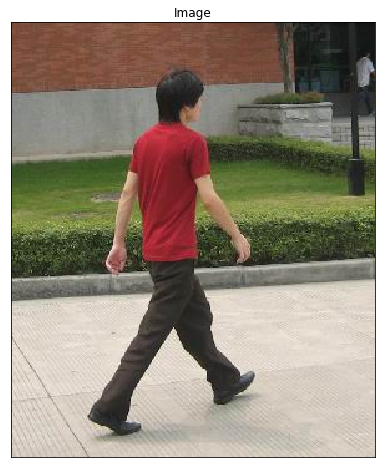

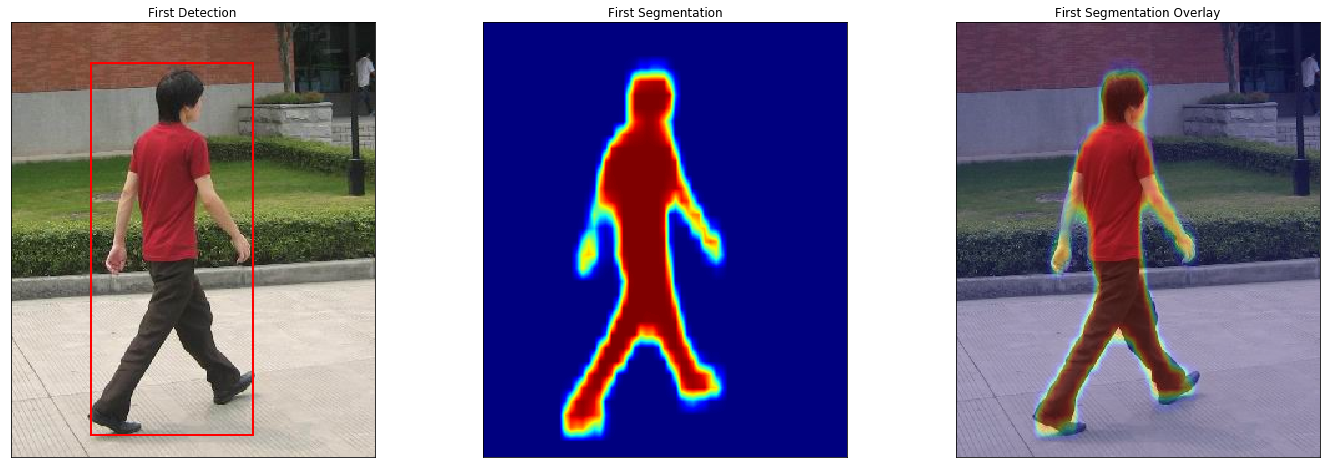

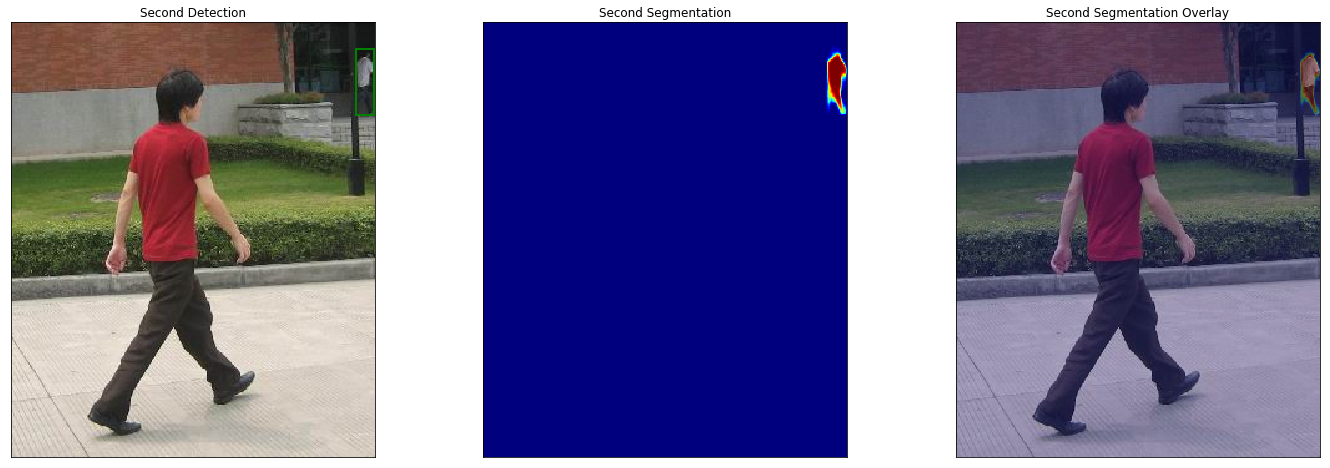

In [0]:
from matplotlib import pyplot as plt
from matplotlib import patches

%matplotlib inline

rect0 = patches.Rectangle((prediction[0]['boxes'][0, 0], prediction[0]['boxes'][0, 1]),
                          prediction[0]['boxes'][0, 2] - prediction[0]['boxes'][0, 0],
                          prediction[0]['boxes'][0, 3] - prediction[0]['boxes'][0, 1],
                          linewidth=2, edgecolor='red', facecolor='none')
rect1 = patches.Rectangle((prediction[0]['boxes'][1, 0], prediction[0]['boxes'][1, 1]),
                          prediction[0]['boxes'][1, 2] - prediction[0]['boxes'][1, 0],
                          prediction[0]['boxes'][1, 3] - prediction[0]['boxes'][1, 1],
                          linewidth=2, edgecolor='green', facecolor='none')

# Original image.
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.imshow(img.mul(255).permute(1, 2, 0).byte().numpy())
ax.set_yticks([])
ax.set_xticks([])
ax.set_title('Image')

plt.show()

# First detection/segmentation.
fig, ax = plt.subplots(1, 3, figsize=(24, 8))

ax[0].imshow(img.mul(255).permute(1, 2, 0).byte().numpy())
ax[0].add_patch(rect0)
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[0].set_title('First Detection')

ax[1].imshow(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy(), 'jet')
ax[1].set_yticks([])
ax[1].set_xticks([])
ax[1].set_title('First Segmentation')

ax[2].imshow(img.mul(255).permute(1, 2, 0).byte().numpy())
ax[2].imshow(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy(), 'jet', alpha=0.3)
ax[2].set_yticks([])
ax[2].set_xticks([])
ax[2].set_title('First Segmentation Overlay')

plt.show()

# Second detection/segmentation.
fig, ax = plt.subplots(1, 3, figsize=(24, 8))

ax[0].imshow(img.mul(255).permute(1, 2, 0).byte().numpy())
ax[0].add_patch(rect1)
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[0].set_title('Second Detection')

ax[1].imshow(prediction[0]['masks'][1, 0].mul(255).byte().cpu().numpy(), 'jet')
ax[1].set_yticks([])
ax[1].set_xticks([])
ax[1].set_title('Second Segmentation')

ax[2].imshow(img.mul(255).permute(1, 2, 0).byte().numpy())
ax[2].imshow(prediction[0]['masks'][1, 0].mul(255).byte().cpu().numpy(), 'jet', alpha=0.3)
ax[2].set_yticks([])
ax[2].set_xticks([])
ax[2].set_title('Second Segmentation Overlay')

plt.show()



<!-- And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1. -->